# Implementación de Automatic Speech Recognition with Transformer (ASR) con lenguaje en Español

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Modifiers:** 
- [Braulio Piña 153058](https://github.com/BraulioPi)<br>
- Brandon Cruz 198573
- Diego Villegas 197902


## Introducción
En esta implementación decidimos usar el dataset de audio en español colombiano, por su disponibilidad y por su mayor parecido al español mexicano.

**Referencias:**

- [Attention is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- [Very Deep Self-Attention Networks for End-to-End Speech Recognition](https://arxiv.org/pdf/1904.13377.pdf)
- [Speech Transformers](https://ieeexplore.ieee.org/document/8462506)
-Dataset usado
- [Crowdsourced high-quality Colombian Spanish [es-co] multi-speaker speech dataset](https://research.google/tools/datasets/colombian-spanish-tts/)

In [1]:
import os
import pathlib
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



#dandole permiso a tensorflow de tragarse toda la RAM
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Paralelización VS GPU
#### Por el tamaño de nuestras GPU'S y las que da colab, con 12 cores corriendo simultaneamente se consigue un speed up de más 50 minutos respecto a uso de TPU y GPU por época.

In [3]:
### Vamos a ahorrar recursos y paralelizar el código, usando todo el poder computacional de mi máquina
# 12 CORES
session_conf = tensorflow.ConfigProto(intra_op_parallelism_threads=12, inter_op_parallelism_threads=12)
tensorflow.set_random_seed(1)
sess = tensorflow.Session(graph=tensorflow.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

## Definiendo la capa de transformer de entrada
Como explican en la documentación de keras, primero se necesita definir la capa de transformer de entrada:
- Se calcula la suma de posiciones incrustadas y de tokens incrustados esto para procesar los tokens objetivo pasados al decodificador
- También, aplicamos capas convolucionales para submuestrear variables de audio. Esto sirve para procesar relaciones locales



In [23]:

class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


## Capa codificadora de transformer

In [24]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Capa decodificadora de transformer

In [25]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


## Completando el modelo de transformer

Our model takes audio spectrograms as inputs and predicts a sequence of characters.
During training, we give the decoder the target character sequence shifted to the left
as input. During inference, the decoder uses its own past predictions to predict the
next token.

In [26]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


# Procesando el dataset
- Los datos los sacamos de aquí:
[Crowdsourced high-quality Colombian Spanish [es-co] multi-speaker speech dataset](https://research.google/tools/datasets/colombian-spanish-tts/)

In [34]:
print(os.getcwd()," :directorio global")
directorio = "./datasets/colombia/wavs"
wavs = glob("{}/**/*.wav".format(directorio), recursive=True)
print("directorio de wavs: ",directorio)
id_to_text = {}
#un poquito de manipulacion de strings
with open(os.path.join("./datasets/colombia", "metadata.csv"), encoding="utf-8") as f:
    #como no tenemos separadores, recortamos el string 
    for line in f:
        id = line[0:21]  #identificador de archivo de audio 
        text = line[21:] #oraciones relacionadas
        id_to_text[id] = text.strip().lower()
        
def get_data(wavs, id_to_text, maxlen=50):
    """ returns mapping of audio paths and transcription texts """
    data = []
    for w in wavs:
        id = w.split("/")[-1].split(".")[0]
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
        else:
            print("es de mas del max len")
    return data


/home/chapulin/Descargas/python_practice/proyecto_deep  :directorio global
directorio de wavs:  ./datasets/colombia/wavs


### Diccionario con nombre de audio y texto asociado

In [35]:
id_to_text

{'com_03349_00001764679': 'el jeroglífico tiene un pez amarillo',
 'com_07508_02061155104': '¿hay algún trabajo en particular que le haya dado como el salto a la fama por así decirlo?',
 'com_02121_01523018450': 'los zapatos se estropearon con la lluvia torrencial de ayer',
 'com_03349_01949076436': 'hay más de setenta estaciones en el centro de la ciudad.',
 'com_07508_01544129049': 'la película me llegó al corazón',
 'com_02484_01542183587': 'me llegó una invitación para un casting pero no conozco bien al director',
 'com_01523_01478480476': 'me puedes confirmar si ya está hecha la reservación',
 'com_05223_00882308176': 'rompa un pedazo de la camisa y amarresela como si fuera un venda',
 'com_03397_01971738736': 'ojalá pudiéramos invitar a ésta junta con la señora maría a varios escritores',
 'com_03034_00801651576': 'quiero celebrar las buenas notas de mi hija.',
 'com_07508_01311699398': 'por las tardes se escucha música en la plaza.',
 'com_00610_00689174621': '¿podrías decirme c

#### Tadam!

## Preprocesamiento de los datos:
- Vectorizacion
- extracción del texto
- Extracción del audio desde los archivos de audio
- Creación de dataset de relación uno a uno entre audio y oraciones

In [33]:
class VectorizeChar:
    def __init__(self, max_len=200):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?","¿","ñ",'á',"é","í","ó","ú"] #
        )
### Como en el español se usan algunos caracteres especiales, tuvimos que incluir las vocales con tilde y la ñ.
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


max_target_len = 300 
data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]
    # padding to 10 seconds
    pad_len = 3000
    #pad_len = 40000

    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


split = int(len(data) * 0.99)
train_data = data[:split]
train_data=data
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)

vocab size 41


### Tenmos un tamaño de vocabulario de 41 por la inclusión de tildes y la letra ñ.

### Como en el español se usan algunos caracteres especiales, tuvimos que incluir las vocales con tilde y la ñ.

## Creando los callbacks para mostrar las prediciones 

In [20]:

class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


## Parametrizando la learning rate

In [12]:

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)


## Modelo usando solamente voz masculina

In [16]:
batch = next(iter(val_ds))

idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=34,
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb], epochs=66)

Epoch 1/66
40/40 [==============================] - 174s 4s/step - loss: 0.7115 - val_loss: 0.6210
target:     <lo puedes cargar a la tarjeta verde de visa>
prediction: <e  ?ploz hgal tl hqe huo ?e r? s s ll le ?foo>

target:     <tengo esa imagen en la cabeza que es un mural medio futurista>
prediction: <e  ?ploz hgal tl hqe huo ?e r? s s ll le ?foo>

target:     <la pelicula me llego al corazon>
prediction: <e  ?ploz hgal tl hqe huo ?e r? s s ll le ?foo>

target:     <la oscuridad del pozo era obscena por naturaleza>
prediction: <e  ?ploz hgal tl hqe huo ?e r? s s ll le ?foo>

Epoch 2/66
40/40 [==============================] - 173s 4s/step - loss: 0.5516 - val_loss: 0.4783
Epoch 3/66
40/40 [==============================] - 177s 4s/step - loss: 0.4857 - val_loss: 0.4457
Epoch 4/66
40/40 [==============================] - 180s 4s/step - loss: 0.4627 - val_loss: 0.4312
Epoch 5/66
40/40 [==============================] - 188s 5s/step - loss: 0.4524 - val_loss: 0.4234
Epoch 6/66
40/40 [

40/40 [==============================] - 198s 5s/step - loss: 0.3154 - val_loss: 0.2554
Epoch 43/66
40/40 [==============================] - 196s 5s/step - loss: 0.3137 - val_loss: 0.2547
Epoch 44/66
40/40 [==============================] - 205s 5s/step - loss: 0.3125 - val_loss: 0.2505
Epoch 45/66
40/40 [==============================] - 192s 5s/step - loss: 0.3099 - val_loss: 0.2472
Epoch 46/66
40/40 [==============================] - 197s 5s/step - loss: 0.3078 - val_loss: 0.2456
target:     <lo puedes cargar a la tarjeta verde de visa>
prediction: <me puedes recomida l casion de la ciudada>

target:     <tengo esa imagen en la cabeza que es un mural medio futurista>
prediction: <el otro dia estera de los mes mas de mexico, son de texas>

target:     <la pelicula me llego al corazon>
prediction: <no se agua la cabara cabara>

target:     <la oscuridad del pozo era obscena por naturaleza>
prediction: <la oscuridad de la comi de la plantacion de lechuga>

Epoch 47/66
40/40 [==========

#### Podemos ver que para dos predicciones, ya tenemos oraciones con coherencia:
- target:     *la pelicula me llego al corazon*
- prediction: la pelicula me llego al corazon

- target:     *la oscuridad del pozo era obscena por naturaleza*
- prediction: la obscuridad del pozo era obscena por naturaleza

## Modelo usando voz femenina y masculina

In [17]:
print(os.getcwd()," :directorio global")
directorio = "./datasets/colombia/wavs_2"
wavs = glob("{}/**/*.wav".format(directorio), recursive=True)
print("directorio de wavs: ",directorio)
id_to_text = {}
#un poquito de manipulacion de strings
with open(os.path.join("./datasets/colombia", "metadata_2.csv"), encoding="utf-8") as f:
    
    for line in f:
        id = line[0:21]
        text = line[21:]
        id_to_text[id] = text.strip().lower()
        
def get_data(wavs, id_to_text, maxlen=50):
    """ returns mapping of audio paths and transcription texts """
    data = []
    for w in wavs:
        id = w.split("/")[-1].split(".")[0]
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
        else:
            print("es de mas del max len")
    return data

max_target_len = 300 
data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))

split = int(len(data) * 0.99)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)


batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=34,
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb], epochs=1)

/home/chapulin/Descargas/python_practice/proyecto_deep  :directorio global
directorio de wavs:  ./datasets/colombia/wavs_2
vocab size 34
76/76 [==============================] - 372s 5s/step - loss: nan - val_loss: nan
target:     <cuales son las principales diferencias?>
prediction: <-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

target:     <el jeroglifico tiene un pez amarillo>
prediction: <-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

target:     <no supo descifrar las huellas>
pred

### Al usar el dataset con voz femenina y masculina, el modelo arroja valores en la función de perdida nulos, lo que nos hace pensar que no se pueden manejar diferentes tonos de voces con el modelo. Quizá por que necesitamos una muestra más grande.

# Limitantes

### Las principales limitantes que encontramos fueron:
- El entrenamiento con voces masculinas y femeninas arrojaba una perdida nula, lo que nos hace pensar que quizá es necesario aumentar el tamaño de muestra de ambos tonos de voces, o quiźa se tenga que hacer algún tipo de adaptación para tonos diferentes.
- Los caracteres especiales del español no son admitidos en la predicción, en especial los acentos, lo que resulta ser una carácterica muy limitativa por la función que cumplen las tildes en el Español escrito, y que a veces son lo que diferencia a una palabra de otra en su escritura y connotación.


 ### Decidimos meterle una cosa extra a nuestro proyecto, queremos ver como se ven las ondas de sonido en nuestro dataset, comparando las de mujeres con hombres.
 - Quizá podamos meterle una capa de procesamiento a nuestros datos para homologar las voces de mujeres y hombres y entrenar un modelo con las voces homologadas.

### Tomaremos dos audios en los que la última palabra es la misma, en este caso la palabra es veracruz, tomaremos uno de hombre y otro de mujeres

In [42]:
dict_compa = {}
dict_compa["com_07049_01309247554"] = id_to_text["com_07049_01309247554"]
dict_compa["cof_02436_00496844118"] = id_to_text["cof_02436_00496844118"]
dict_compa

{'com_07049_01309247554': 'que decian las noticias locales en veracruz?',
 'cof_02436_00496844118': 'como se llama el gobernador de veracruz?'}

In [2]:
##directorio de los audios de interés 
data_dir =  "./datasets/colombia/comparaciones"
### Extrayendo los audios
filenames = tf.io.gfile.glob(str(data_dir) + '/*')
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print(filenames)

Number of total examples: 2
['./datasets/colombia/comparaciones/com_07049_01309247554.wav', './datasets/colombia/comparaciones/cof_02436_00496844118.wav']


In [3]:
##diccionario con archivo y text
dic = {'./datasets/colombia/comparaciones/com_07049_01309247554.wav': 'que decian las noticias locales en veracruz?',
 './datasets/colombia/comparaciones/cof_02436_00496844118.wav': 'como se llama el gobernador de veracruz?'}

In [4]:
#decodificando audio
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

#forma de la onda de sonido
def get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform

lista = []#extrayendo los tensores que incluyen los datos de la onda de sonido
for i in dic.keys():
    lista.append([get_waveform(i),dic[i]])
lista

[[<tf.Tensor: shape=(208896,), dtype=float32, numpy=
  array([-3.3569336e-04, -2.7465820e-04, -3.9672852e-04, ...,
          3.0517578e-05, -3.0517578e-05,  6.1035156e-05], dtype=float32)>,
  'que decian las noticias locales en veracruz?'],
 [<tf.Tensor: shape=(241664,), dtype=float32, numpy=
  array([-3.0517578e-05, -9.1552734e-05, -1.2207031e-04, ...,
         -6.1035156e-05, -9.1552734e-05, -1.5258789e-04], dtype=float32)>,
  'como se llama el gobernador de veracruz?']]

## Oraciones completas 
- Primero veamos las oraciones completas, se observan las ondas correspondientes a la última palabra, que es Veracruz. También se observan similaridades, veamos con más detalle.

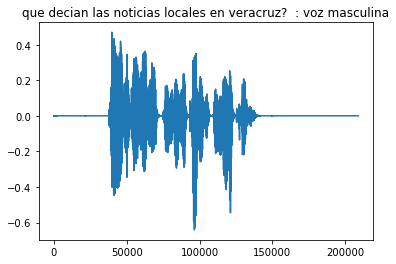

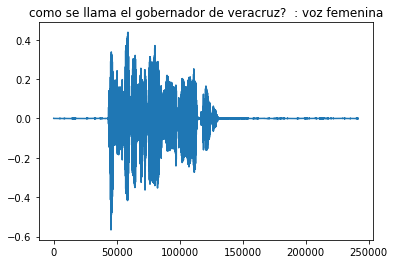

In [23]:
plt.figure()
plt.plot(lista[0][0][30:])
plt.title(lista[0][1]+"  : voz masculina")
plt.show()
plt.figure()
plt.plot(lista[1][0][0:])
plt.title(lista[1][1]+"  : voz femenina")
plt.show()

### Aislemos las ondas correspondientes a Veracruz

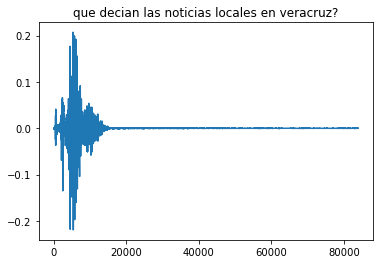

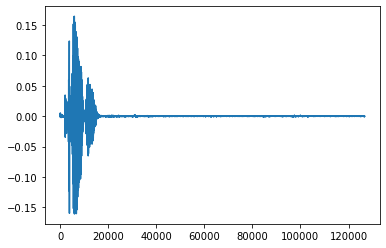

In [49]:
plt.figure()
plt.plot(lista[0][0][125000:])
plt.title(lista[0][1])
plt.show()
plt.figure()
plt.plot(lista[1][0][115000:])
plt.show()

## tensores correspondientes a la palabra Veracruz

In [51]:
lista[0][0][125000:]

<tf.Tensor: shape=(83896,), dtype=float32, numpy=
array([-1.5258789e-04,  2.4414062e-04,  3.9672852e-04, ...,
        3.0517578e-05, -3.0517578e-05,  6.1035156e-05], dtype=float32)>

In [37]:
lista[1][0][115000:]

<tf.Tensor: shape=(126664,), dtype=float32, numpy=
array([ 2.6245117e-03,  2.7465820e-03,  2.5024414e-03, ...,
       -6.1035156e-05, -9.1552734e-05, -1.5258789e-04], dtype=float32)>

### Escalando el tensor de mujeres

In [61]:
escalado = lista[1][0][115000:]-.03

In [62]:
escalado

<tf.Tensor: shape=(126664,), dtype=float32, numpy=
array([-0.02737549, -0.02725342, -0.02749756, ..., -0.03006103,
       -0.03009155, -0.03015259], dtype=float32)>

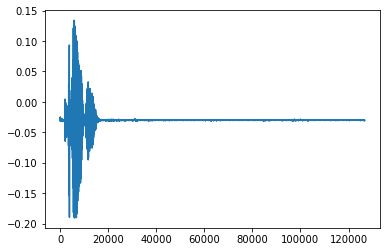

In [63]:
plt.figure()
plt.plot(escalado)
plt.show()

#### Podemos ver que escalando los tensores, se puede lograr una calibración de voces.
- Quizá en investigaciones futuras, se pueda generar una capa de escalamiento de tensores, lo cual sería útil para predecir con modelos que quizá estén entrenados con pocos datos o pocos diferentes tonos de voces.

### Trabajos relacionados:
- Si quieres ver algo de transferencia con imagenes, quizá pueda servir de inspiración a archivos de audio.
- Lo que se hizo en esta comparacion de imagenes, es de alguna manera una forma de hacer lo mismo que ascenso por gradiente con audios.
- Link de trabajo ejemplo: https://github.com/BraulioPi/Deep-Dream-Brau/blob/master/Arte%20con%20redes%20neuronales.ipynb